Dans le cadre d'une stratégie de maintenance prédictive et d'amélioration continue des performances des modèles de clustering, il est essentiel de suivre l'évolution de la stabilité des clusters au fil du temps. Cette stabilité peut être mesurée par l'indice de Rand ajusté (ARI), qui compare la similarité des clusters obtenus à différents moments. La mise en place d'un contrat de maintenance inclut donc des étapes de surveillance régulière et des réajustements des modèles pour garantir une segmentation client cohérente et fiable:

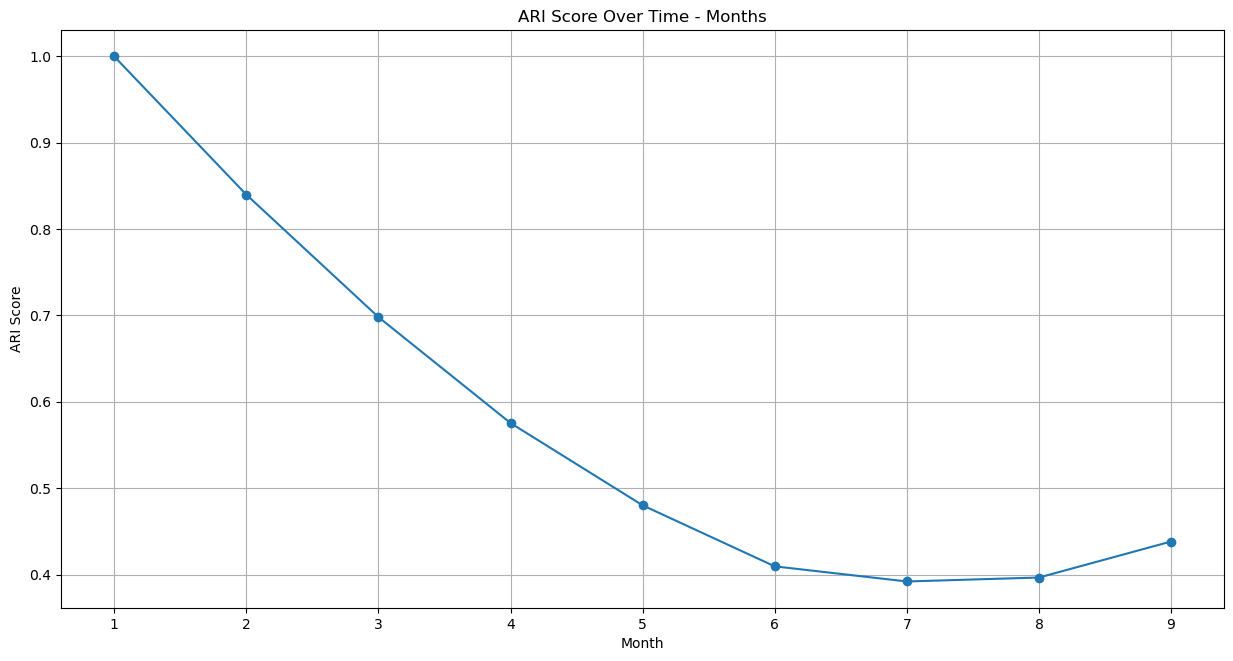

In [1]:
from datetime import datetime, timedelta
import sqlite3
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

def generate_first_of_months(start_date, end_date):
    """
    Génère une liste des premiers jours de chaque mois entre deux dates données.

    Args:
        start_date (datetime): La date de début.
        end_date (datetime): La date de fin.

    Returns:
        list: Une liste de chaînes de caractères représentant les premiers jours de chaque mois.
    """
    current_date = start_date
    first_of_months = []
    while current_date <= end_date:
        first_of_months.append(current_date.strftime('%Y-%m-%d'))
        if current_date.month == 12:
            current_date = current_date.replace(year=current_date.year + 1, month=1, day=1)
        else:
            current_date = current_date.replace(month=current_date.month + 1, day=1)
    return first_of_months

# Dates de début et de fin pour générer les premiers jours de chaque mois
start_date = datetime(2018, 1, 1)
end_date = datetime(2018, 9, 1)

# Génération des premiers jours de chaque mois
first_of_months = generate_first_of_months(start_date, end_date)

# Connexion à la base de données
conn = sqlite3.connect("olist.db")

def sql_query(i):    
    """
    Exécute une requête SQL pour récupérer des données clients à une date donnée.

    Args:
        i (str): Une chaîne représentant la date (format 'YYYY-MM-DD').

    Returns:
        pd.DataFrame: Un DataFrame contenant les données récupérées depuis la base de données.
    """
    query = pd.read_sql_query(f"""
    WITH location AS (
        SELECT geolocation_zip_code_prefix, AVG(geolocation_lat) AS latt, AVG(geolocation_lng) AS long
        FROM geoloc
        GROUP BY geolocation_zip_code_prefix),
    pricing AS (
        SELECT order_id, SUM(price) AS sales, AVG(freight_value/(price + freight_value)) AS shipping,
               SUM(price + freight_value) AS total
        FROM (
            SELECT DISTINCT order_items.order_id, order_items.seller_id, order_items.price, order_items.freight_value
            FROM order_items)
        GROUP BY order_id)
    SELECT customer_unique_id, COUNT(*) AS total_purchase, latt, long, customer_state,
           (julianday(date('{i}')) - julianday(MIN(order_purchase_timestamp))) / 30.42 AS seniority,
           MAX(order_purchase_timestamp) AS latest_purchase,
           AVG(julianday(order_estimated_delivery_date) - julianday(order_purchase_timestamp)) AS delivery_time,
           AVG(julianday(order_delivered_customer_date) - julianday(order_estimated_delivery_date)) AS delay,
           sales, shipping, total, AVG(review_score) AS average_score
    FROM customers
    LEFT JOIN location ON customers.customer_zip_code_prefix = location.geolocation_zip_code_prefix
    LEFT JOIN orders ON customers.customer_id = orders.customer_id AND orders.order_purchase_timestamp < '{i}'
    LEFT JOIN pricing ON orders.order_id = pricing.order_id
    LEFT JOIN order_reviews ON orders.order_id = order_reviews.order_id
    WHERE orders.order_status = 'delivered'
    GROUP BY customer_unique_id
    ORDER BY total_purchase DESC
    """, conn)
    return pd.DataFrame(query)

# Dictionnaire pour stocker les données à chaque mois
T = {}

# Boucle pour récupérer et transformer les données pour chaque mois
for j in range(9):
    i = first_of_months[j]
    T[j] = sql_query(i)
    T[j] = T[j].set_index('customer_unique_id')
    T[j]['latest_purchase'] = pd.to_datetime(T[j]['latest_purchase'], format="%Y-%m-%d %H:%M:%S")
    T[j]['latest_purchase'] = pd.to_datetime(T[j]['latest_purchase'])
    reference_date = pd.Timestamp(i)
    T[j]['latest_purchase_numeric'] = (reference_date - T[j]['latest_purchase']) // pd.Timedelta('1D')
    T[j].loc[T[j]['average_score'].isna(), 'average_score'] = 2.5
    T[j].loc[T[j]['delay'].isna(), 'delay'] = 0
    customer_state = list(T[j]['customer_state'].value_counts().index)
    for k in customer_state:
        T[j].loc[(T[j]['customer_state'] == k) & (T[j]['latt'].isna()), 'latt'] = \
            T[j].loc[T[j]['customer_state'] == k, 'latt'].median()
        T[j].loc[(T[j]['customer_state'] == k) & (T[j]['long'].isna()), 'long'] = \
            T[j].loc[T[j]['customer_state'] == k, 'long'].median()

# Sélection des colonnes pour RFM
rfm = ['total_purchase', 'total', 'latest_purchase_numeric','average_score']

# Initialisation du modèle KMeans pour le premier mois
X = T[0][rfm].values
scaler_t0 = StandardScaler()
X_scaled_t0 = scaler_t0.fit_transform(X)
kmeans_t0 = KMeans(n_clusters=6, random_state=42, n_init='auto')
kmeans_t0.fit(X_scaled_t0)

results = []

# Boucle pour analyser les données des mois suivants
for i in range(9):
    new_data_values = T[i][rfm].values
    new_data_scaled = scaler_t0.transform(new_data_values)
    clusters_init = kmeans_t0.predict(new_data_scaled)
    scaler_new = StandardScaler()
    new_data_scaled_new = scaler_new.fit_transform(new_data_values)
    kmeans_new = KMeans(n_clusters=6, random_state=42, n_init='auto')
    clusters_new = kmeans_new.fit_predict(new_data_scaled_new)
    ari_score = adjusted_rand_score(clusters_init, clusters_new)
    results.append({
        'clusters_init': clusters_init,
        'clusters_new': clusters_new,
        'ari_score': ari_score})

# Calcul des scores ARI pour chaque mois
ari_scores = [result['ari_score'] for result in results]
months = range(1, len(ari_scores) + 1)

# Visualisation des scores ARI au fil des mois
plt.figure(figsize=(15, 7.5))
plt.plot(months, ari_scores, marker='o')
plt.xlabel('Month')
plt.ylabel('ARI Score')
plt.title('ARI Score Over Time - Months')
plt.grid()
plt.show()

Le graphique ci-dessus illustre l'évolution de l'ARI au cours des mois, mettant en évidence une tendance à la baisse de la stabilité des clusters au fil du temps. Ce constat souligne l'importance d'une approche proactive pour réentraîner les modèles et adapter les clusters en fonction des changements dans les données clients.

Afin de renforcer cette surveillance, une approche plus granulaire a été adoptée, en analysant l'ARI à une fréquence hebdomadaire, ce qui permet de détecter plus précocement les variations de performance des clusters. Le code qui suit détaille la méthodologie employée pour effectuer cette analyse fine, en générant des points de contrôle hebdomadaires, calculant les nouveaux clusters, et évaluant leur alignement avec les clusters initiaux à l'aide de l'ARI.

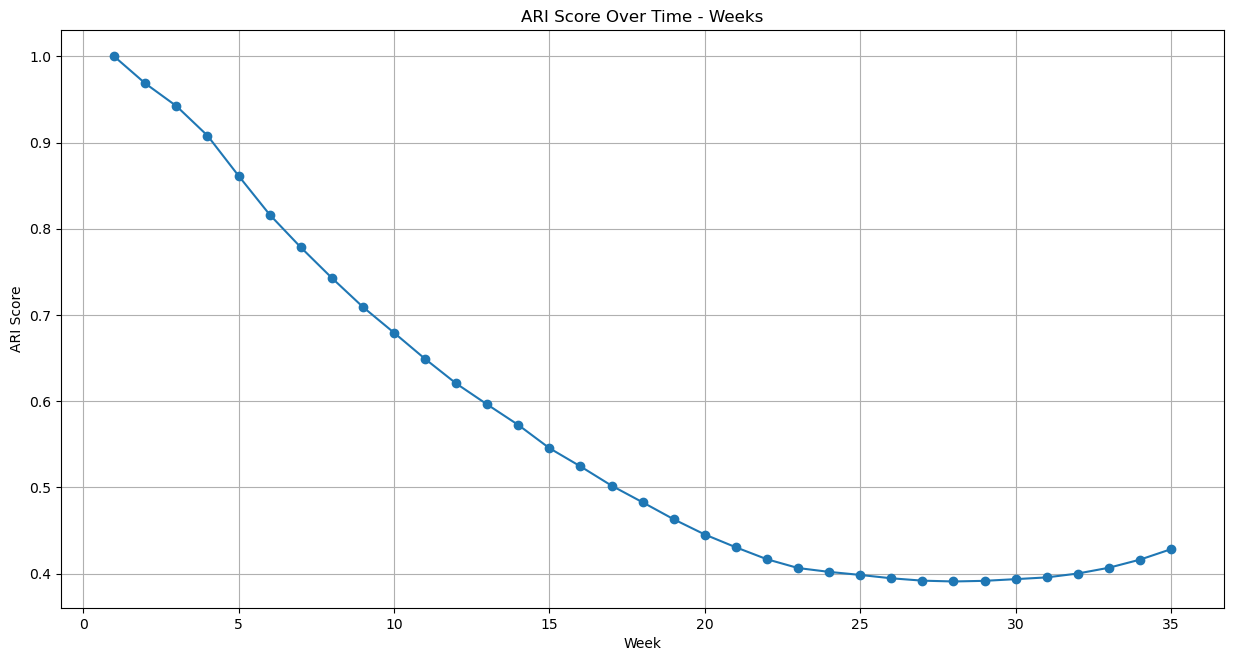

In [2]:
def generate_first_of_weeks(start_date, end_date):
    """
    Génère une liste des premiers jours de chaque semaine entre deux dates données.

    Args:
        start_date (datetime): La date de début.
        end_date (datetime): La date de fin.

    Returns:
        list: Une liste de chaînes de caractères représentant les premiers jours de chaque semaine.
    """
    current_date = start_date
    first_of_weeks = []
    while current_date <= end_date:
        first_of_weeks.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=7)
    return first_of_weeks

# Définir les dates de début et de fin pour générer les premiers jours de chaque semaine
start_date = datetime(2018, 1, 1)
end_date = datetime(2018, 9, 1)

# Génération des premiers jours de chaque semaine
first_of_weeks = generate_first_of_weeks(start_date, end_date)

def sql_query(i):
    """
    Exécute une requête SQL pour récupérer des données clients à une date donnée.

    Args:
        i (str): Une chaîne représentant la date (format 'YYYY-MM-DD').

    Returns:
        pd.DataFrame: Un DataFrame contenant les données récupérées depuis la base de données.
    """
    query = pd.read_sql_query(f"""
    WITH location AS (
        SELECT geolocation_zip_code_prefix, AVG(geolocation_lat) AS latt, AVG(geolocation_lng) AS long
        FROM geoloc
        GROUP BY geolocation_zip_code_prefix),
    pricing AS (
        SELECT order_id, SUM(price) AS sales, AVG(freight_value/(price + freight_value)) AS shipping,
               SUM(price + freight_value) AS total
        FROM (
            SELECT DISTINCT order_items.order_id, order_items.seller_id, order_items.price, order_items.freight_value
            FROM order_items)
        GROUP BY order_id)
    SELECT customer_unique_id, COUNT(*) AS total_purchase, latt, long, customer_state,
           (julianday(date('{i}')) - julianday(MIN(order_purchase_timestamp))) / 30.42 AS seniority,
           MAX(order_purchase_timestamp) AS latest_purchase,
           AVG(julianday(order_estimated_delivery_date) - julianday(order_purchase_timestamp)) AS delivery_time,
           AVG(julianday(order_delivered_customer_date) - julianday(order_estimated_delivery_date)) AS delay,
           sales, shipping, total, AVG(review_score) AS average_score
    FROM customers
    LEFT JOIN location ON customers.customer_zip_code_prefix = location.geolocation_zip_code_prefix
    LEFT JOIN orders ON customers.customer_id = orders.customer_id AND orders.order_purchase_timestamp < '{i}'
    LEFT JOIN pricing ON orders.order_id = pricing.order_id
    LEFT JOIN order_reviews ON orders.order_id = order_reviews.order_id
    WHERE orders.order_status = 'delivered'
    GROUP BY customer_unique_id
    ORDER BY total_purchase DESC
    """, conn)
    return pd.DataFrame(query)

# Dictionnaire pour stocker les données à chaque semaine
T = {}

# Boucle pour récupérer et transformer les données pour chaque semaine
for j in range(len(first_of_weeks)):
    i = first_of_weeks[j]
    T[j] = sql_query(i)
    T[j] = T[j].set_index('customer_unique_id')
    T[j]['latest_purchase'] = pd.to_datetime(T[j]['latest_purchase'], format="%Y-%m-%d %H:%M:%S")
    T[j]['latest_purchase'] = pd.to_datetime(T[j]['latest_purchase'])
    reference_date = pd.Timestamp(i)
    T[j]['latest_purchase_numeric'] = (reference_date - T[j]['latest_purchase']) // pd.Timedelta('1D')
    T[j].loc[T[j]['average_score'].isna(), 'average_score'] = 2.5
    T[j].loc[T[j]['delay'].isna(), 'delay'] = 0
    customer_state = list(T[j]['customer_state'].value_counts().index)
    for k in customer_state:
        T[j].loc[(T[j]['customer_state'] == k) & (T[j]['latt'].isna()), 'latt'] = \
            T[j].loc[T[j]['customer_state'] == k, 'latt'].median()
        T[j].loc[(T[j]['customer_state'] == k) & (T[j]['long'].isna()), 'long'] = \
            T[j].loc[T[j]['customer_state'] == k, 'long'].median()

# Initialisation du modèle KMeans pour la première semaine
X = T[0][rfm].values
scaler_t0 = StandardScaler()
X_scaled_t0 = scaler_t0.fit_transform(X)
kmeans_t0 = KMeans(n_clusters=6, random_state=42, n_init='auto')
kmeans_t0.fit(X_scaled_t0)

results = []

# Boucle pour analyser les données des semaines suivantes
for i in range(len(first_of_weeks)):
    new_data_values = T[i][rfm].values
    new_data_scaled = scaler_t0.transform(new_data_values)
    clusters_init = kmeans_t0.predict(new_data_scaled)
    scaler_new = StandardScaler()
    new_data_scaled_new = scaler_new.fit_transform(new_data_values)
    kmeans_new = KMeans(n_clusters=6, random_state=42, n_init='auto')
    clusters_new = kmeans_new.fit_predict(new_data_scaled_new)
    ari_score = adjusted_rand_score(clusters_init, clusters_new)
    results.append({
        'clusters_init': clusters_init,
        'clusters_new': clusters_new,
        'ari_score': ari_score})

# Calcul des scores ARI pour chaque semaine
ari_scores = [result['ari_score'] for result in results]
weeks = range(1, len(ari_scores) + 1)

# Visualisation des scores ARI au fil des semaines
plt.figure(figsize=(15, 7.5))
plt.plot(weeks, ari_scores, marker='o')
plt.xlabel('Week')
plt.ylabel('ARI Score')
plt.title('ARI Score Over Time - Weeks')
plt.grid()
plt.show()

Au terme de cette analyse, il apparaît que la stabilité des clusters de clients diminue progressivement au fil des mois, avec une baisse marquée de l'Indice de Rand Ajusté (ARI). Cela indique que les segments de clients, initialement définis, deviennent de moins en moins pertinents au fil du temps. Pour maintenir la pertinence des segments et assurer la performance du modèle de segmentation, il est crucial de mettre à jour régulièrement les clusters.

Compte tenu des résultats obtenus, qui montrent une dégradation progressive mais non immédiate, il est recommandé de procéder à une mise à jour des clusters tous les 1 mois et demi. Ce délai permet de garantir une réactivité suffisante face aux changements dans les comportements des clients, tout en évitant des ajustements trop fréquents qui pourraient s'avérer coûteux et inefficaces. Cette fréquence de mise à jour assure un bon équilibre entre précision et efficacité dans la gestion des segments clients.